In [54]:
# Google Colab 환경에서 작성
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder

import random
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import seaborn as sns

In [56]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [57]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(41) # Seed 고정

In [58]:
path = "/content/drive/MyDrive/인공지능응용/"

dataT = pd.read_csv(path+"train_T.csv")
dataO = pd.read_csv(path+"train_O.csv")

# original data -> data
data = pd.concat([dataT, dataO]).reset_index(drop=True)
processed_data = data.copy()
processed_data = processed_data.fillna(0)

# 2. 같은 값으로만 채워진 column 삭제 (nunique(dropna=False) <= 1)
# Get the counts of unique values per column
value_counts = processed_data.iloc[:,4:].apply(lambda x: x.nunique(dropna=False))

# Filter columns with only one unique value
unique_columns = value_counts[value_counts >= 2].index
duplicated_columns = value_counts[value_counts <= 1].index

processed_data = processed_data.drop(duplicated_columns, axis=1)

# 3. 모든 행이 같은 값을 가지는 두 개 이상의 중복된 column 삭제
df = processed_data.iloc[:,4:].T.drop_duplicates(keep='first').T
processed_data = pd.concat([processed_data.iloc[:,:4], df], axis=1)

# 4. Regularization
rs = RobustScaler()
ss = StandardScaler()

processed_data.iloc[:, 4:] = rs.fit_transform(processed_data.iloc[:, 4:])

# 5. Label Encoding
cat_cols = ['PRODUCT_CODE', 'LINE']

for col in cat_cols:
    le = LabelEncoder()
    processed_data[col] = le.fit_transform(processed_data[col])


In [59]:
input_data = processed_data.copy()

# Divide processed_data to abnormal and normal
normal_data = input_data[input_data['Y_Class']==1]
normal_data['Y_Class'] = normal_data['Y_Class'].replace({1: 0}) # normal -> 0

undershoot = processed_data[processed_data['Y_Class']==0]
overshoot = processed_data[processed_data['Y_Class']==2]
abnormal_data = pd.concat([undershoot, overshoot])
abnormal_data['Y_Class'] = abnormal_data['Y_Class'].replace({2: 1, 0: 1}) # abnormal -> 1

print('Normal Data:', normal_data.shape, ', Abnormal Data:', abnormal_data.shape)

# Create test data (normal 100, abnormal 100 = 200)
test_normal = normal_data.sample(n = 100, random_state = 42)
test_abnormal = abnormal_data.sample(n = 100, random_state = 42)
test_data = pd.concat([test_normal, test_abnormal])

print('Test Data:', test_data.shape)

# Create train data based on normal data (638)
train_normal = normal_data.drop(test_normal.index)
train_abnormal = abnormal_data.drop(test_abnormal.index)
train_data = pd.concat([train_normal, train_abnormal])

print('Train Data:', train_data.shape)

# Create train data without abnormal data (536) for Anomaly Detection
train_normal_data = train_data[train_data['Y_Class']==0]

print('Train Normal Data:', train_normal_data.shape)

Normal Data: (636, 682) , Abnormal Data: (202, 682)
Test Data: (200, 682)
Train Data: (638, 682)
Train Normal Data: (536, 682)


<ipython-input-59-b1887964d7a6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal_data['Y_Class'] = normal_data['Y_Class'].replace({1: 0}) # normal -> 0


In [60]:
train_df = train_normal_data.copy()
val_df = test_data.copy()

In [61]:
# from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
# from sklearn.preprocessing import LabelEncoder

# train_df1 = pd.read_csv('/content/drive/MyDrive/인공지능응용/train_T.csv')
# train_df2 = pd.read_csv('/content/drive/MyDrive/인공지능응용/train_O.csv')
# train_df = pd.concat([train_df1, train_df2]).reset_index(drop=True)

# # Preprocessed data -> processed_data
# processed_data = train_df.copy()

# # 1. Handling missing values
# processed_data = processed_data.fillna(0)

# # 2. 같은 값으로만 채워진 column 삭제 (nunique(dropna=False) <= 1)
# # Get the counts of unique values per column
# value_counts = processed_data.iloc[:,4:].apply(lambda x: x.nunique(dropna=False))
# # Filter columns with only one unique value
# unique_columns = value_counts[value_counts >= 2].index
# duplicated_columns = value_counts[value_counts <= 1].index
# processed_data = processed_data.drop(duplicated_columns, axis=1)

# # 3. 모든 행이 같은 값을 가지는 두 개 이상의 중복된 column 삭제
# df = processed_data.iloc[:,4:].T.drop_duplicates(keep='first').T
# processed_data = pd.concat([processed_data.iloc[:,:4], df], axis=1)

# # 4. Regularization
# rs = RobustScaler()
# ss = StandardScaler()
# processed_data.iloc[:, 4:] = rs.fit_transform(processed_data.iloc[:, 4:])

# # 5. Label Encoding
# cat_cols = ['PRODUCT_CODE', 'LINE']
# for col in cat_cols:
#     le = LabelEncoder()
#     processed_data[col] = le.fit_transform(processed_data[col])
#     print(le.classes_)
# #train_df = processed_data.copy()
# #train_df['Y_Class'] = train_df['Y_Class'].replace({0:1, 2:1, 1:0}) # 이상치는 1, 정상은 0

In [62]:
# # Divide processed_data to abnormal and normal
# normal_data = processed_data[processed_data['Y_Class']==1]
# normal_data['Y_Class'] = normal_data['Y_Class'].replace({1: 0}) # normal -> 0

# undershoot = processed_data[processed_data['Y_Class']==0]
# overshoot = processed_data[processed_data['Y_Class']==2]
# abnormal_data = pd.concat([undershoot, overshoot])
# abnormal_data['Y_Class'] = abnormal_data['Y_Class'].replace({2: 1, 0: 1}) # abnormal -> 1
# #normal_data = normal_data.iloc[:, :4]
# #abnormal_data = abnormal_data.iloc[:, :4]

# # Create test data (normal 202, abnormal 202 = 404)
# test_normal = normal_data.sample(n = 202, random_state = 42)
# test_data = pd.concat([test_normal, abnormal_data])

# # Create train data based on normal data (636 - 202 = 434)
# train_normal = normal_data.drop(test_normal.index)


# # #Divide data to X  data and y data
# # train_y = train_normal['Y_Class']
# # train_df = train_normal.drop(['Y_Class'], axis=1)
# # test_y = test_data['Y_Class']
# # test_X = test_data.drop(['Y_Class'], axis=1)

# train_df = train_normal.copy()
# val_df = test_data.copy()

In [63]:
# val_df = train_df[train_df['Y_Class']==1]
# train_df = train_df[train_df['Y_Class']==0]

In [64]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [65]:
batch_size = 16

In [66]:
class MyDataset(Dataset):
    def __init__(self, df, eval_mode):
        self.df = df
        self.eval_mode = eval_mode
        self.labels = self.df['Y_Class'].values
        self.conds1 = self.df['PRODUCT_CODE'].values
        self.conds2 = self.df['LINE'].values
        self.df = self.df.drop(columns=['Y_Class'])
        self.df = self.df.drop(columns=['Y_Quality'])
        self.df = self.df.drop(columns=['LINE', 'PRODUCT_CODE'])
        self.df = self.df.values

    def __getitem__(self, index):
        x = torch.Tensor(self.df[index])
        condition1 = torch.tensor(self.conds1[index], dtype=torch.long)
        condition2 = torch.tensor(self.conds2[index], dtype=torch.long)

        if self.eval_mode:
            y = torch.tensor(self.labels[index], dtype=torch.long)  # 레이블 추가
            return x, y, condition1, condition2  # 데이터, 레이블, 조건 반환
        else:
            return x, condition1, condition2  # 데이터, 조건 반환

    def __len__(self):
        return len(self.df)

In [67]:
train_dataset = MyDataset(df=train_df, eval_mode=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = MyDataset(df = val_df, eval_mode=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [68]:
class GANnomaly(object):

    def __init__(self):
        self.encoder = Encoder().to(device)
        self.decoder = Decoder().to(device)
        self.discriminator = Discriminator().to(device)

        self.models = [self.encoder, self.decoder, self.discriminator]

        self.params = None
        for idx_m, model in enumerate(self.models):
            if (self.params is None):
                self.params = list(model.parameters())
            else:
                self.params = self.params + list(model.parameters())

        self.optimizer = optim.Adam(self.params, lr=0.0002)

class Encoder(nn.Module):

    def __init__(self):
        super(Encoder, self).__init__()

        self.encoder = nn.Sequential(
          nn.Linear(678, 512),
          nn.BatchNorm1d(512),
          nn.LeakyReLU(),
          nn.Linear(512, 256),
          nn.BatchNorm1d(256),
          nn.LeakyReLU(),
          nn.Linear(256, 128),
          nn.BatchNorm1d(128),
          nn.LeakyReLU(),
          nn.Linear(128, 64),
          nn.BatchNorm1d(64),
          nn.LeakyReLU(),
        )

    def forward(self, x):

        z_code = self.encoder(x)

        return z_code

class Decoder(nn.Module):

    def __init__(self):
        super(Decoder, self).__init__()
        self.condition1_size = 2  # 4개의 라벨에 대한 원-핫 인코딩 크기
        self.condition1_layer = nn.Linear(self.condition1_size,2)
        self.condition2_size = 2  # 4개의 라벨에 대한 원-핫 인코딩 크기
        self.condition2_layer = nn.Linear(self.condition2_size,2)

        self.decoder = nn.Sequential(
          nn.Linear(64+4, 128),
          nn.BatchNorm1d(128),
          nn.LeakyReLU(),
          nn.Linear(128, 256),
          nn.BatchNorm1d(256),
          nn.LeakyReLU(),
          nn.Linear(256, 512),
          nn.BatchNorm1d(512),
          nn.LeakyReLU(),
          nn.Linear(512, 678)
        )

    def forward(self, z, condition1, condition2):
        # 조건을 원-핫 인코딩으로 변환
        condition1 = F.one_hot(condition1, num_classes=self.condition1_size).float()
        condition1 = self.condition1_layer(condition1)
        condition2 = F.one_hot(condition2, num_classes=self.condition2_size).float()
        condition2 = self.condition2_layer(condition2)

        # 조건부 정보와 z를 결합
        z = torch.cat([z, condition1, condition2], 1)

        # 나머지 디코더 네트워크를 통과
        x_hat = self.decoder(z)
        return x_hat



class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        self.condition1_size = 2  # 조건 크기
        self.condition1_layer = nn.Linear(self.condition1_size, 2)
        self.condition2_size = 2  # 조건 크기
        self.condition2_layer = nn.Linear(self.condition2_size, 2)

        self.dis_dense = nn.Sequential(
           nn.Linear(678+4, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )


    def forward(self, x, condition1, condition2):
        # 조건을 원-핫 인코딩으로 변환
        condition1 = F.one_hot(condition1, num_classes=self.condition1_size).float()
        condition1 = self.condition1_layer(condition1)
        condition2 = F.one_hot(condition2, num_classes=self.condition2_size).float()
        condition2 = self.condition2_layer(condition2)

        # 조건부 정보와 x를 결합
        x = torch.cat([x, condition1, condition2], 1)

        featurebank = []

        # self.dis_dense의 각 레이어를 순차적으로 호출하면서 중간 출력을 featurebank에 저장
        for idx, layer in enumerate(self.dis_dense):
            x = layer(x)
            if("torch.nn.modules.activation" in str(type(layer))):
                featurebank.append(x)

        disc_score = x  # 최종 출력

        return disc_score, featurebank


In [69]:
def loss_enc(z_code, z_code_hat):

    l_enc = torch.sum((z_code - z_code_hat)**2, dim=(1))

    return l_enc

def loss_rec(x, x_hat):
    l_con = torch.sum(torch.abs(x - x_hat), dim=(1))

    return l_con

def loss_adv(dis_x, dis_x_hat, features_real, features_fake):

    l_adv = torch.sum((dis_x - dis_x_hat)**2, dim=(1))


    for fidx, _ in enumerate(features_real):

        l_adv += torch.sum((features_real[fidx] - features_fake[fidx])**2, dim=(1))

    return l_adv


def loss_gan(z_code, z_code_hat, x, x_hat,
    dis_x, dis_x_hat, features_real, features_fake,
    w_enc=1, w_con=10, w_adv=1):


    z_code, z_code_hat, x, x_hat = z_code, z_code_hat, x, x_hat

    for fidx, _ in enumerate(features_real):
        features_real[fidx] = features_real[fidx]
        features_fake[fidx] = features_fake[fidx]

    l_enc = loss_enc(z_code, z_code_hat)
    l_con = loss_rec(x, x_hat)
    l_adv = loss_adv(dis_x, dis_x_hat, features_real, features_fake)


    l_tot = torch.mean((w_enc * l_enc) + (w_con * l_con) + (w_adv * l_adv))

    l_enc = torch.mean(l_enc)
    l_con = torch.mean(l_con)
    l_adv = torch.mean(l_adv)


    return l_tot, l_enc, l_con, l_adv

In [70]:
epochs = 2000
cos = nn.CosineSimilarity(dim=1, eps=1e-8)

model = GANnomaly()
model.encoder.train()
model.decoder.train()
model.discriminator.train()

encoder_loss_per_epoch = []
decoder_loss_per_epoch = []

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model.optimizer, mode='min', factor=0.3, patience=15, threshold_mode='abs', min_lr=1e-8, verbose=True)


for i in range(1,epochs+1) :

    train_loss = []
    encoder_loss = []
    decoder_loss = []
    disc_loss = []
    best_score = 0

    for idx, (data, condition1, condition2) in enumerate(train_loader):

        x = data.to(device)
        condition1 = condition1.to(device)
        condition2 = condition2.to(device)

        # Encoder와 Decoder의 forward pass
        z_code = model.encoder(x)
        x_hat = model.decoder(z_code, condition1, condition2)
        z_code_hat = model.encoder(x_hat)

        dis_x, features_real = model.discriminator(x, condition1, condition2)
        dis_x_hat, features_fake = model.discriminator(x_hat, condition1, condition2)


        l_tot, l_enc, l_con, l_adv = loss_gan(z_code, z_code_hat,
                                       x, x_hat,
                                       dis_x, dis_x_hat,
                                       features_real, features_fake)

        model.optimizer.zero_grad()
        l_tot.backward()
        model.optimizer.step()

        train_loss.append(l_tot.item())
        encoder_loss.append(l_enc.item())
        decoder_loss.append(l_con.item())
        disc_loss.append(l_adv.item())

        avg_encoder_loss = sum(encoder_loss) / len(encoder_loss)
        avg_decoder_loss = sum(decoder_loss) / len(decoder_loss)
        encoder_loss_per_epoch.append(avg_encoder_loss)
        decoder_loss_per_epoch.append(avg_decoder_loss)


    print(f'Epoch : [{i}] Train loss : [{np.mean(train_loss)}] Encoder loss : [{np.mean(encoder_loss)}] Decoder loss : [{np.mean(decoder_loss)}] Disc loss : [{np.mean(disc_loss)}] )')

    score = np.mean(train_loss)
   # scheduler.step(score)
    scheduler.step(np.mean(train_loss))

    if best_score < score:
        best_score = score
        torch.save(model.encoder.state_dict(), 'best_encoder.pth', _use_new_zipfile_serialization=False)
        torch.save(model.decoder.state_dict(), 'best_decoder.pth', _use_new_zipfile_serialization=False)

Epoch : [1] Train loss : [96673.3243336397] Encoder loss : [26.157652293934543] Decoder loss : [9631.442917767694] Disc loss : [332.7380905151367] )
Epoch : [2] Train loss : [96893.57441980699] Encoder loss : [14.90703418675591] Decoder loss : [9675.714096966913] Disc loss : [121.52503024830537] )
Epoch : [3] Train loss : [94762.48759191176] Encoder loss : [8.554638035157147] Decoder loss : [9469.336680692784] Disc loss : [60.566260393928076] )
Epoch : [4] Train loss : [93312.69966394761] Encoder loss : [10.678323970121497] Decoder loss : [9321.769407384536] Disc loss : [84.32777326247272] )
Epoch : [5] Train loss : [92016.49472943474] Encoder loss : [9.0478553351234] Decoder loss : [9194.704147338867] Disc loss : [60.40566556593951] )
Epoch : [6] Train loss : [93287.76545266544] Encoder loss : [7.1434456460616165] Decoder loss : [9322.332159603344] Disc loss : [57.29951134849997] )
Epoch : [7] Train loss : [91318.93195657169] Encoder loss : [5.5440756853889015] Decoder loss : [9127.89

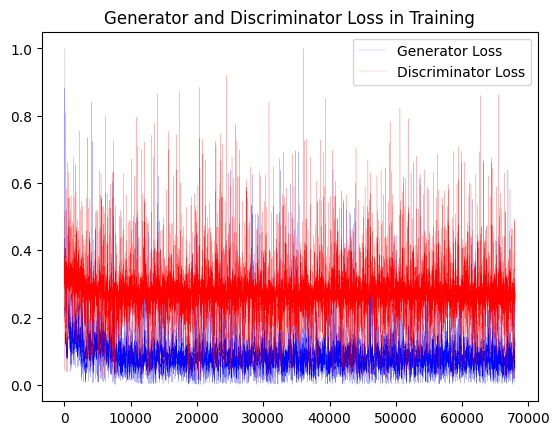

In [71]:
#visualize results
import matplotlib.pyplot as plt

vis_encoder_loss = [x / max(encoder_loss_per_epoch) for x in encoder_loss_per_epoch]
vis_decoder_loss = [x / max(decoder_loss_per_epoch) for x in decoder_loss_per_epoch]


plt.plot(vis_encoder_loss,'b',label='Generator Loss',linewidth=0.1)
plt.plot(vis_decoder_loss,'r',label='Discriminator Loss',linewidth=0.1)

plt.title('Generator and Discriminator Loss in Training')
plt.legend()
plt.show()

In [72]:
model = GANnomaly()
model.encoder.load_state_dict(torch.load('best_encoder.pth'))
model.decoder.load_state_dict(torch.load('best_decoder.pth'))
model.encoder.eval()
model.decoder.eval()

Decoder(
  (condition1_layer): Linear(in_features=2, out_features=2, bias=True)
  (condition2_layer): Linear(in_features=2, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=68, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Linear(in_features=512, out_features=678, bias=True)
  )
)

In [73]:
def calculate_anomaly_score(x, x_hat):
    return torch.sum(torch.abs(x - x_hat), dim=1)

def feature_scale(anomaly_scores):
    min_score = np.min(anomaly_scores)
    max_score = np.max(anomaly_scores)
    return (anomaly_scores - min_score) / (max_score - min_score)

model.encoder.eval()
model.decoder.eval()

val_anomaly_scores = []

with torch.no_grad():
    for data, _, conds1, conds2 in val_loader:
        data = data.to(device)
        conds1 = conds1.to(device)
        conds2 = conds2.to(device)

        # 인코더와 디코더를 통한 데이터의 재구성
        reconstructed_data = model.decoder(model.encoder(data), conds1, conds2)

        # 이상치 점수 계산
        anomaly_score = calculate_anomaly_score(data, reconstructed_data)
        val_anomaly_scores.extend(anomaly_score.cpu().numpy())

scaled_anomaly_scores = feature_scale(np.array(val_anomaly_scores))

In [74]:
thr = 0.5

pred_GAN = np.where(scaled_anomaly_scores < thr,1,0)

print(f1_score(pred_GAN,val_df['Y_Class'],average='macro'))
print(confusion_matrix(val_df['Y_Class'],pred_GAN))

0.3899308386940896
[[ 8 92]
 [ 9 91]]


In [75]:
print(classification_report(val_df['Y_Class'],pred_GAN))

              precision    recall  f1-score   support

           0       0.47      0.08      0.14       100
           1       0.50      0.91      0.64       100

    accuracy                           0.49       200
   macro avg       0.48      0.49      0.39       200
weighted avg       0.48      0.49      0.39       200



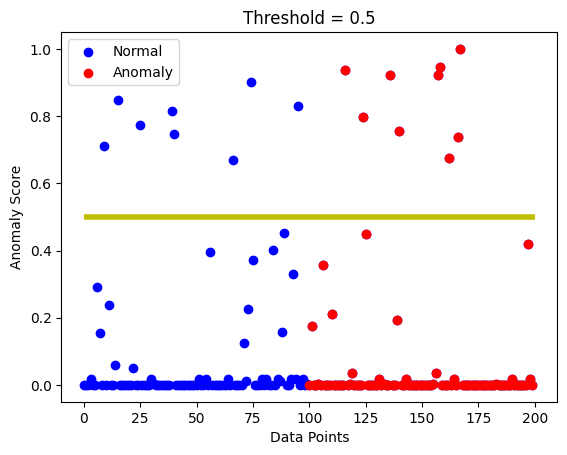

In [76]:
# 시각화 코드 추가
threshold_vis = 0.5
threshold_score = 0.5

plt.scatter(range(len(scaled_anomaly_scores)), scaled_anomaly_scores, c='b', label='Normal')
plt.scatter(np.array(range(len(scaled_anomaly_scores)))[val_df['Y_Class'] == 1], scaled_anomaly_scores[val_df['Y_Class'] == 1], c='r', label='Anomaly')
plt.hlines(threshold_score, xmin=0, xmax=len(scaled_anomaly_scores), colors='y', linewidth=4)

plt.title(f'Threshold = {threshold_vis}')
plt.xlabel('Data Points')
plt.ylabel('Anomaly Score')
plt.legend()
plt.show()

accuracy:  0.495
recall:  0.91
precision:  0.497
f1-score:  0.643


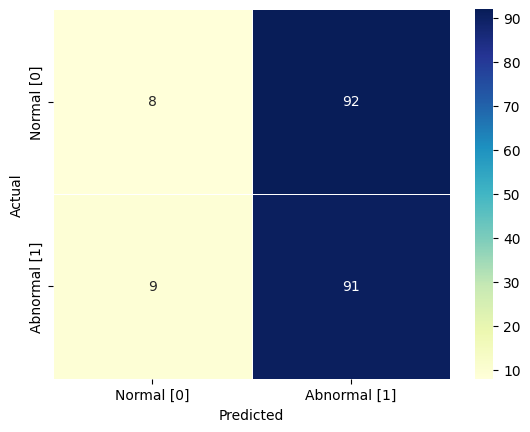

In [77]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score

con_mat = confusion_matrix(val_df['Y_Class'].values, pred_GAN)

sns.heatmap(pd.DataFrame(con_mat, columns = ['Predicted', 'Actual']),
            xticklabels=['Normal [0]', 'Abnormal [1]'],
            yticklabels=['Normal [0]', 'Abnormal [1]'],
            annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
plt.ylabel('Actual')
plt.xlabel('Predicted')

print("accuracy: ", accuracy_score(val_df['Y_Class'].values, pred_GAN))
print("recall: ", round(recall_score(val_df['Y_Class'].values, pred_GAN),3))
print("precision: ", round(precision_score(val_df['Y_Class'].values, pred_GAN),3))
print("f1-score: ", round(f1_score(val_df['Y_Class'].values, pred_GAN),3))